<a href="https://colab.research.google.com/github/bchenley/MachineLearningPortfolio/blob/main/Notebooks/DimensionalityReduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import Modules

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score

from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.decomposition import PCA, FactorAnalysis, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.manifold import TSNE

Clone GitHub repo.

In [ ]:
!git clone https://github.com/bchenley/MachineLearningPortfolio.git

Cloning into 'MachineLearningPortfolio'...
remote: Enumerating objects: 1738, done.
remote: Counting objects: 100% (362/362), done.
remote: Compressing objects: 100% (223/223), done.
remote: Total 1738 (delta 251), reused 201 (delta 138), pack-reused 1376
Receiving objects: 100% (1738/1738), 13.22 MiB | 7.78 MiB/s, done.
Resolving deltas: 100% (1002/1002), done.
Updating files: 100% (54/54), done.


Change directory to repo `src`.

In [ ]:
%cd MachineLearningPortfolio/src

/content/MachineLearningPortfolio/src


Install requirements (if needed).

In [ ]:
# !pip install -r requirements.txt

Import modules from repo

In [ ]:
from eda import describe, annotate_bar, Descriptor
from preprocessing import log_transform
from decomposition import eig

Get data [here](https://www.kaggle.com/code/bchenley/notebook8a3323af75/edit#:~:text=human%2Dactivity%2D-,recognition,-%2Dwith%2Dsmartphones).

Import the data.

In [ ]:
train_path = '/content/drive/MyDrive/IK/data/Kaggle/ActivityRecognition/train.csv'
test_path = '/content/drive/MyDrive/IK/data/Kaggle/ActivityRecognition/test.csv'

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

Identify variables. The variable `subject` corresponds to the subject ID.

In [ ]:
# All variables
X_name = df_train.drop(columns = ['subject'], axis = 1).columns.tolist()

# Categorical variables
X_name_cat = df_train.select_dtypes(include = ['object']).columns.tolist()

# Numeric variables
X_name_num = [name for name in X_name if name not in X_name_cat]

print(f"{len(X_name)} variables in dataset.")
print(f"{len(X_name_cat)} categorical variables.")
print(f"{len(X_name_num)} categorical variables.")

562 variables in dataset.
1 categorical variables.
561 categorical variables.


Summarize the data.

In [ ]:
X_num_train_summary = describe(df_train[X_name_num])
X_cat_train_summary = describe(df_train[X_name_cat])

In [ ]:
X_num_train_summary[['count', 'mean', 'std', '50%', 'max', 'skew', 'missing']]

,count,mean,std,50%,max,skew,missing
tBodyAcc-mean()-X,7352,0.274488,0.070261,0.277193,1.000000,-3.447619,0
tBodyAcc-mean()-Y,7352,-0.017695,0.040811,-0.017219,1.000000,-0.402912,0
tBodyAcc-mean()-Z,7352,-0.109141,0.056635,-0.108676,1.000000,1.784105,0
tBodyAcc-std()-X,7352,-0.605438,0.448734,-0.946196,1.000000,0.677292,0
tBodyAcc-std()-Y,7352,-0.510938,0.502645,-0.851897,0.916238,0.405809,0
...,...,...,...,...,...,...,...
"angle(tBodyGyroMean,gravityMean)",7352,0.008726,0.608303,0.008735,0.998702,-0.017952,0
"angle(tBodyGyroJerkMean,gravityMean)",7352,-0.005981,0.477975,-0.000368,0.996078,0.001497,0
"angle(X,gravityMean)",7352,-0.489547,0.511807,-0.709417,1.000000,1.399676,0
"angle(Y,gravityMean)",7352,0.058593,0.297480,0.182071,0.478157,-1.501183,0


In [ ]:
X_cat_train_summary[['count', 'mode', 'cardinality', 'missing']]

,count,mode,cardinality,missing
Activity,7352,LAYING,6,0


Identify activity labels.

In [ ]:
y_train = df_train[['Activity']]
y_test = df_test[['Activity']]

y_label_encoder = LabelEncoder()
y_train_label_encoded = pd.DataFrame(y_label_encoder.fit_transform(y_train.values.squeeze()),
                                     columns = ['Activity'],
                                     index = y_train.index)
y_test_label_encoded = pd.DataFrame(y_label_encoder.transform(y_test.values.squeeze()),
                                    columns = ['Activity'],
                                    index = y_test.index)

y_train_onehot_encoded = pd.get_dummies(y_train, drop_first = True)
y_test_onehot_encoded = pd.get_dummies(y_test, drop_first = True)

activity_labels = np.unique(df_train['Activity']).tolist()

print(activity_labels)

['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']


Explore Activity data.

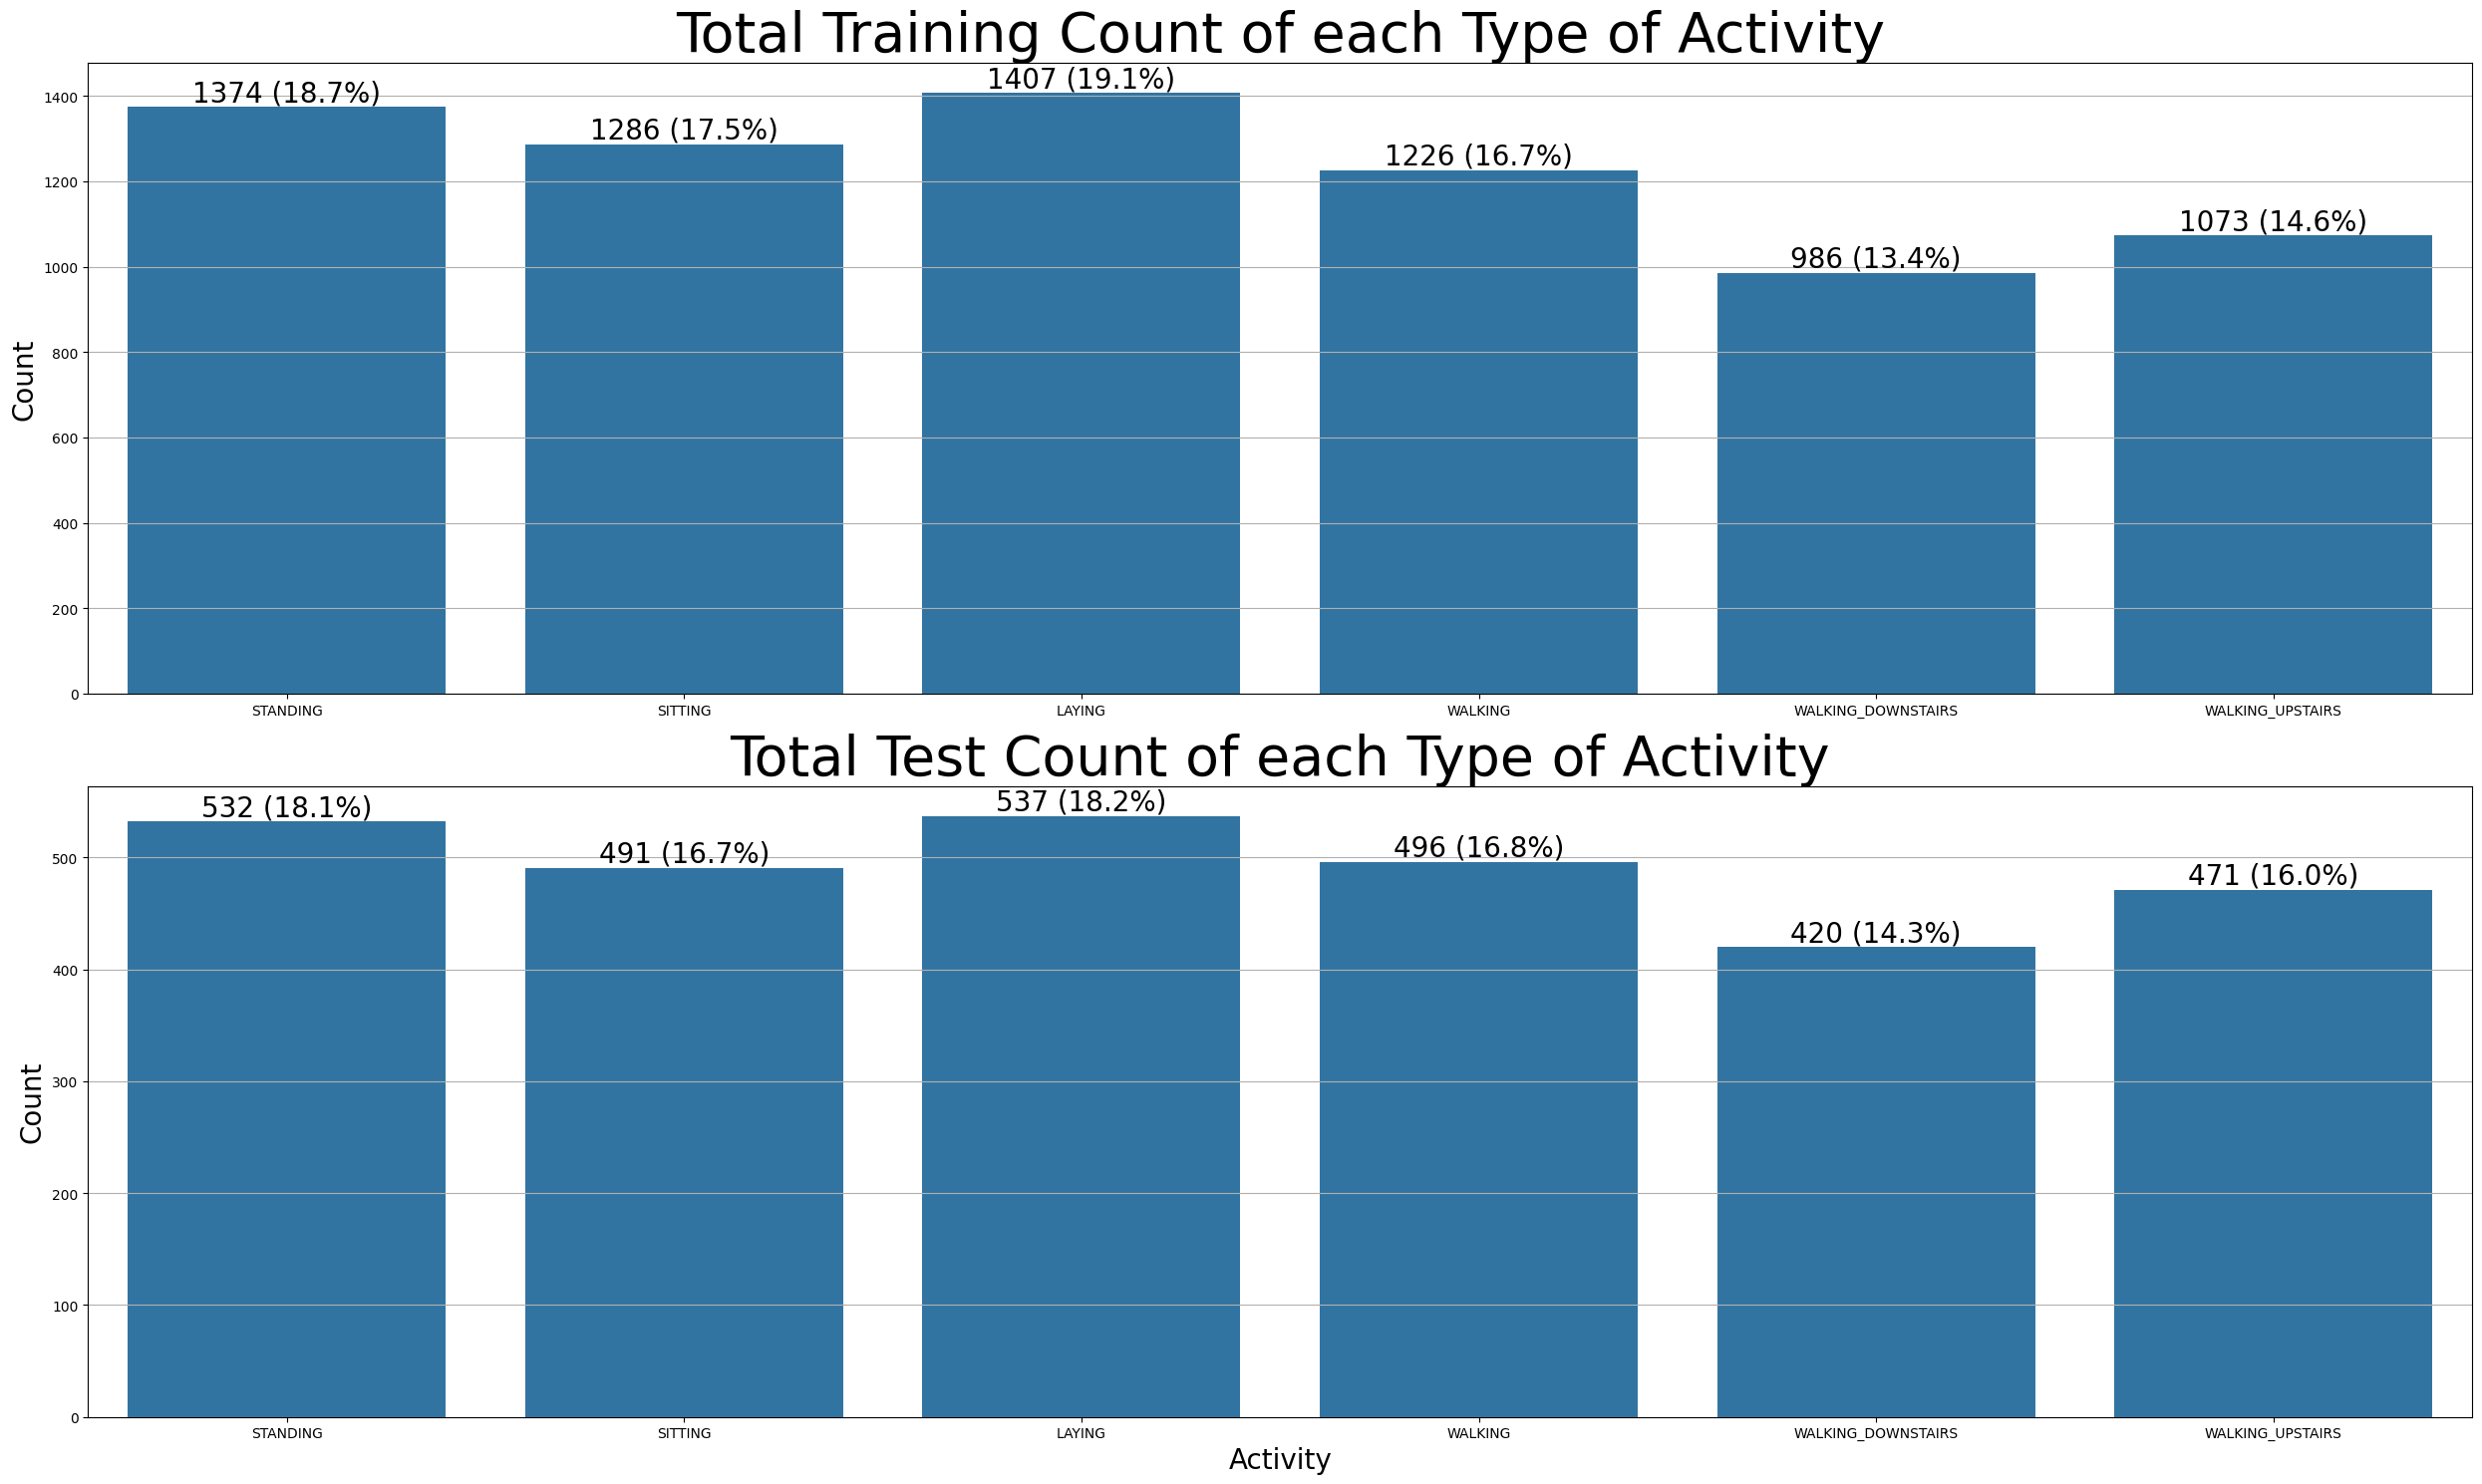

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (25, 15))

# Training data
sns.countplot(data = df_train,
              x = 'Activity',
              ax = ax[0])

ax[0].set_title("Total Training Count of each Type of Activity", fontsize = 40)
ax[0].set_ylabel('Count', fontsize = 20)
ax[0].set_xlabel(None)
ax[0].yaxis.grid(True)

annotate_bar(ax[0], show_percent = True, decimals = 0, fontsize = 20)

# Test data
sns.countplot(data = df_test,
              x = 'Activity',
              ax = ax[1])

ax[1].set_title("Total Test Count of each Type of Activity", fontsize = 40)
ax[1].set_ylabel('Count', fontsize = 20)
ax[1].set_xlabel('Activity', fontsize = 20)
ax[1].yaxis.grid(True)

annotate_bar(ax[1], show_percent = True, decimals = 0, fontsize = 20)

plt.tight_layout()

Identify and clip outliers in numerical data.

In [ ]:
df_train_clipped = df_train.copy()
df_test_clipped = df_test.copy()

train_outliers = {}
test_outliers = {}

x_range = [1, 99]
scale = 3.

for x in X_name_num:

  train_descriptor = Descriptor(df_train[x].values)
  test_descriptor = Descriptor(df_test[x].values)

  train_outlier_values, train_outlier_idx = train_descriptor.outliers(range = x_range, scale = scale)
  test_outlier_values, test_outlier_idx = test_descriptor.outliers(range = x_range, scale = scale)

  train_outliers[x] = len(train_outlier_values)
  test_outliers[x] = len(test_outlier_values)

  ## Option 1: forward fill outliers
  df_train_clipped.loc[train_outlier_idx[0], x] = np.nan
  df_test_clipped.loc[test_outlier_idx[0], x] = np.nan

  df_train_clipped[x] = df_train_clipped[x].fillna(method = 'ffill')
  df_test_clipped[x] = df_test_clipped[x].fillna(method = 'ffill')
  ##

  ## # Another option: clipp data at the point where value becomes an outlier
  # train_x_clipped = train_descriptor.clip(range = x_range, scale = scale)
  # test_x_clipped = test_descriptor.clip(range = x_range, scale = scale)

  # df_train_clipped[x] = train_x_clipped
  # df_test_clipped[x] = test_x_clipped
  ##

train_outliers = pd.DataFrame(train_outliers, index = ['train'])
test_outliers = pd.DataFrame(test_outliers, index = ['test'])

df_outliers = pd.concat([train_outliers.T, test_outliers.T], axis = 1)

Inpsect outliers (if desired).

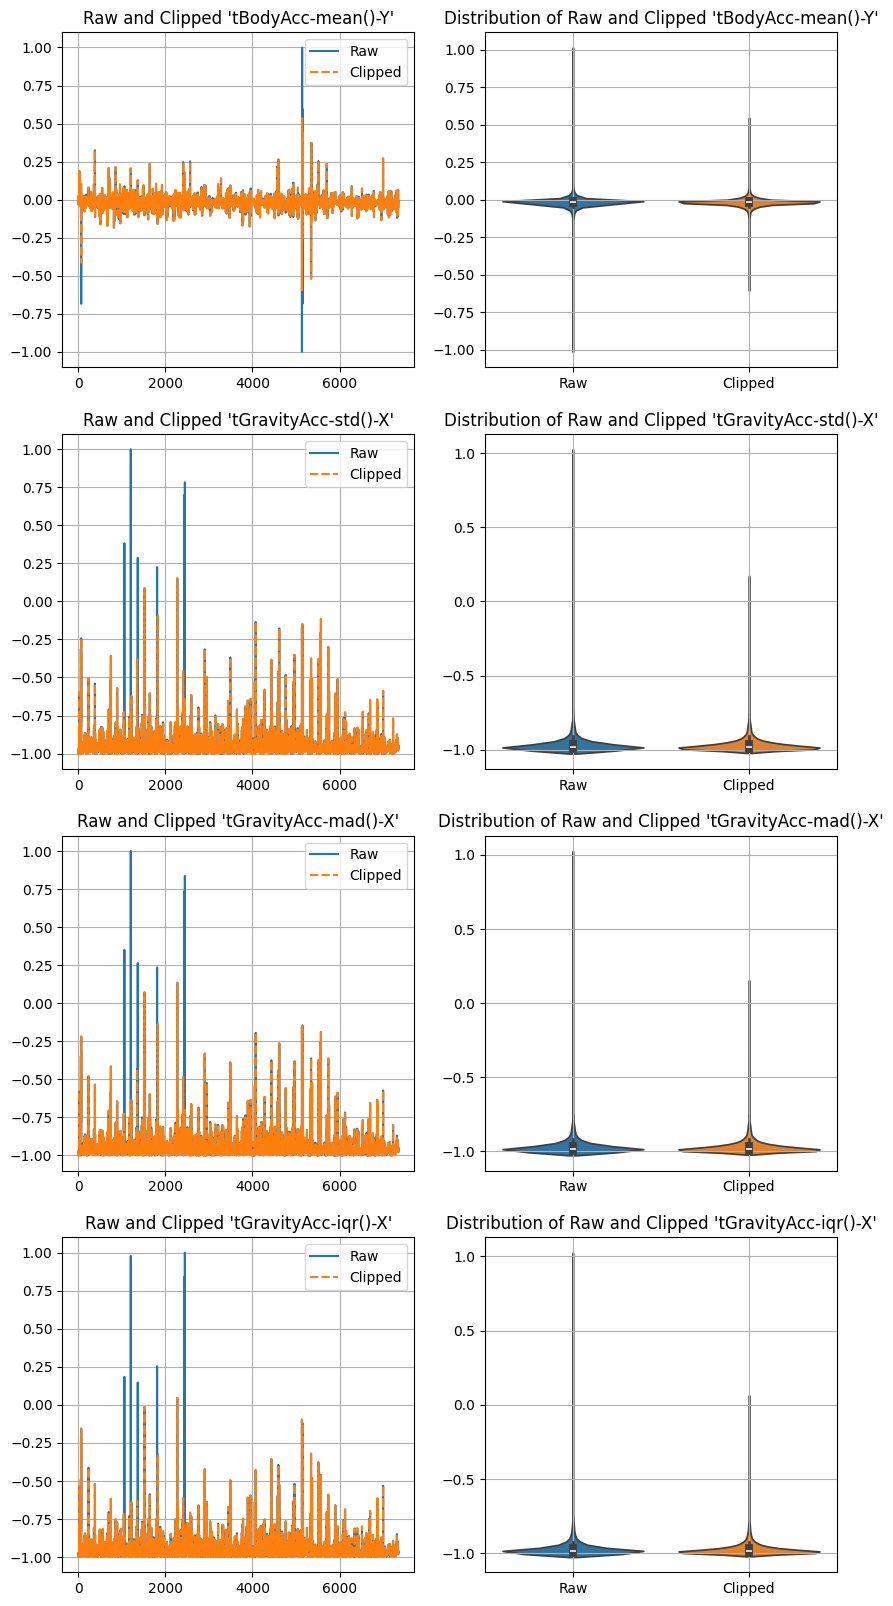

In [ ]:
# Get variables with most outliers
X_train_name_top_outliers = df_outliers['train'].sort_values(ascending = False).index.tolist()[:4]

fig, ax = plt.subplots(4, 2, figsize = (10, 20))

for i, x in enumerate(X_train_name_top_outliers):

  df_ = pd.concat((df_train[[x]], df_train_clipped[[x]]), axis = 1)
  df_.columns = ['Raw', 'Clipped']

  sns.lineplot(data = df_,
               ax = ax[i, 0])
  sns.violinplot(data = df_,
                 ax = ax[i, 1])

  ax[i, 0].set_title(f"Raw and Clipped '{x}'")
  ax[i, 1].set_title(f"Distribution of Raw and Clipped '{x}'")

  ax[i, 0].grid(True)
  ax[i, 1].grid(True)

The high dimensionality of our data (561 features) raises the question of whether data can be reduced. Let's consider the main approaches we learned in class:

**Linear methods**
1. Principal Component Analysis (PCA)
2. Factor Analysis (FA)
3. Linear Discriminant Analysis (LDA)

(We also talked about truncated SVD, but this is for sparse data)

**Nonlinear methods**
4. Kernel PCA
5. t-Distributed Stochastic Neighbor Embedding (t-SNE)
6. Multidimensional Scaling (MDS)
7. Isomap

Before we begin, let us scale the data:

In [ ]:
standard_scaler = StandardScaler()

df_train_scaled = df_train_clipped.copy()
df_test_scaled = df_test_clipped.copy()

df_train_scaled[X_name_num] = standard_scaler.fit_transform(df_train_scaled[X_name_num])
df_test_scaled[X_name_num] = standard_scaler.transform(df_test_scaled[X_name_num])

## Principal Component Analysis (PCA)

Apply PCA to the scaled training data.

In [ ]:
pca = PCA()
pca.fit(df_train_scaled[X_name_num]) ;

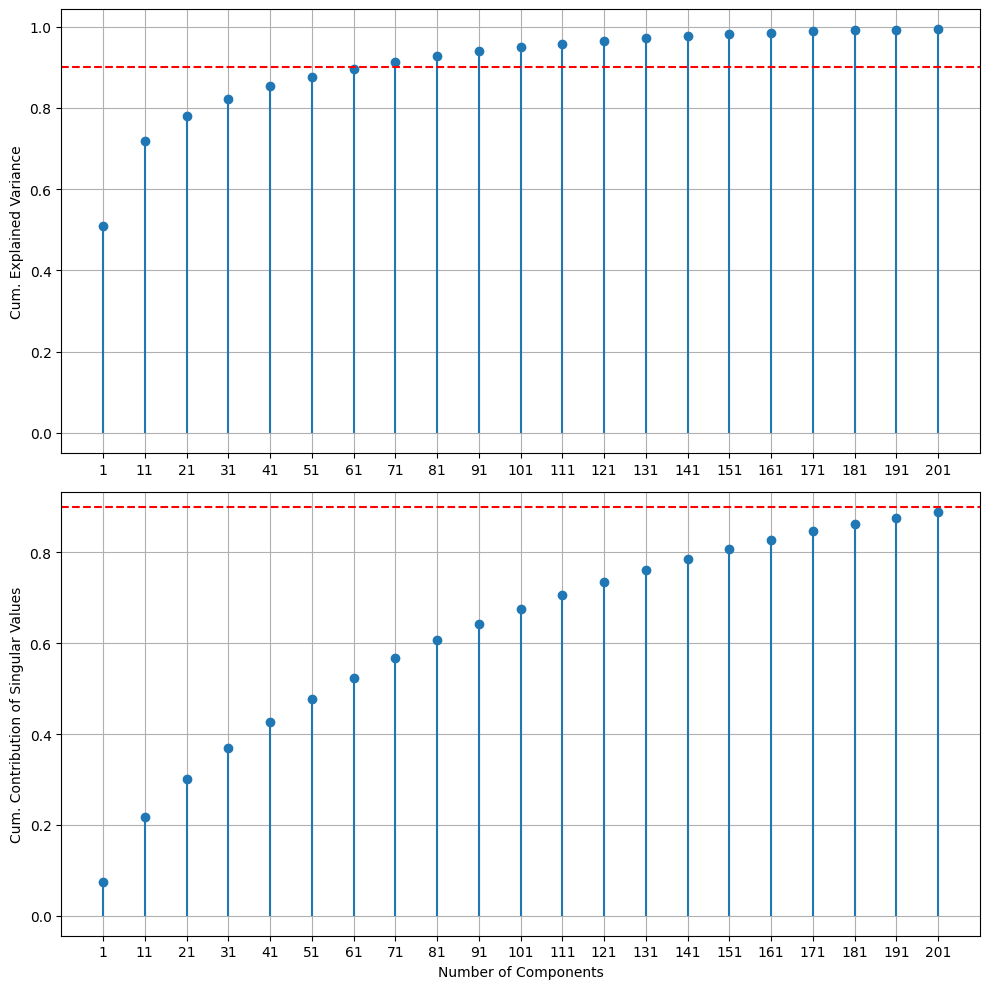

In [ ]:
cumulative_explained_variance_ratio_ = pca.explained_variance_ratio_.cumsum()/pca.explained_variance_ratio_.sum()
cumulative_sval = pca.singular_values_.cumsum()/pca.singular_values_.sum()

x = np.arange(1, len(cumulative_explained_variance_ratio_) + 1)

N, step = 210, 10

fig, ax = plt.subplots(2, 1, figsize = (10, 10))
# Cumulative explained variance
ax[0].stem(x[:N:step], cumulative_explained_variance_ratio_[:N:step],
           basefmt = " ")
ax[0].set_xticks(x[:N:step])
ax[0].set_ylabel("Cum. Explained Variance")
ax[0].grid(True)
ax[0].axhline(y = 0.9, linestyle = '--', color = 'r')

# Cumulative contribution of singular values
ax[1].stem(x[:N:step], cumulative_sval[:N:step],
         basefmt = " ")
ax[1].set_xticks(x[:N:step])
ax[1].set_xlabel("Number of Components")
ax[1].set_ylabel("Cum. Contribution of Singular Values") ;
ax[1].grid(True)
ax[1].axhline(y = 0.9, linestyle = '--', color = 'r')

plt.tight_layout()

Let's select the minimum number of PCs that covers 90% over the variance in the data.

In [ ]:
random_state = 42

threshold = 0.9

pca = PCA(n_components = threshold, random_state = random_state)
pca.fit(df_train_scaled[X_name_num]) ;

In [ ]:
n_pc = len(pca.singular_values_)
explained_variance_pct = pca.explained_variance_ratio_.cumsum().max()*100

print(f"Percent variance explained: {explained_variance_pct:.2f}")
print(f"Number of PCs to cover 90% of variance: {n_pc}")

Percent variance explained: 90.16
Number of PCs to cover 90% of variance: 64


Store the projected data in a dataframe. Each column represents "score", or representation of the data in one of the dimensions of the PC space.

In [ ]:
# Train
df_train_pc_score = pd.DataFrame(pca.transform(df_train_scaled[X_name_num]),
                                 columns = [f'score_{i+1}' for i in range(n_pc)])

# Test
df_test_pc_score = pd.DataFrame(pca.transform(df_test_scaled[X_name_num]),
                                columns = [f'score_{i+1}' for i in range(n_pc)])

Let's image that we know the true activity corresponding to each sample (we actually do). We know that the first score has the most variance and the last score has the least. Let's plot the scores against each other, two at a time, in descinding order.

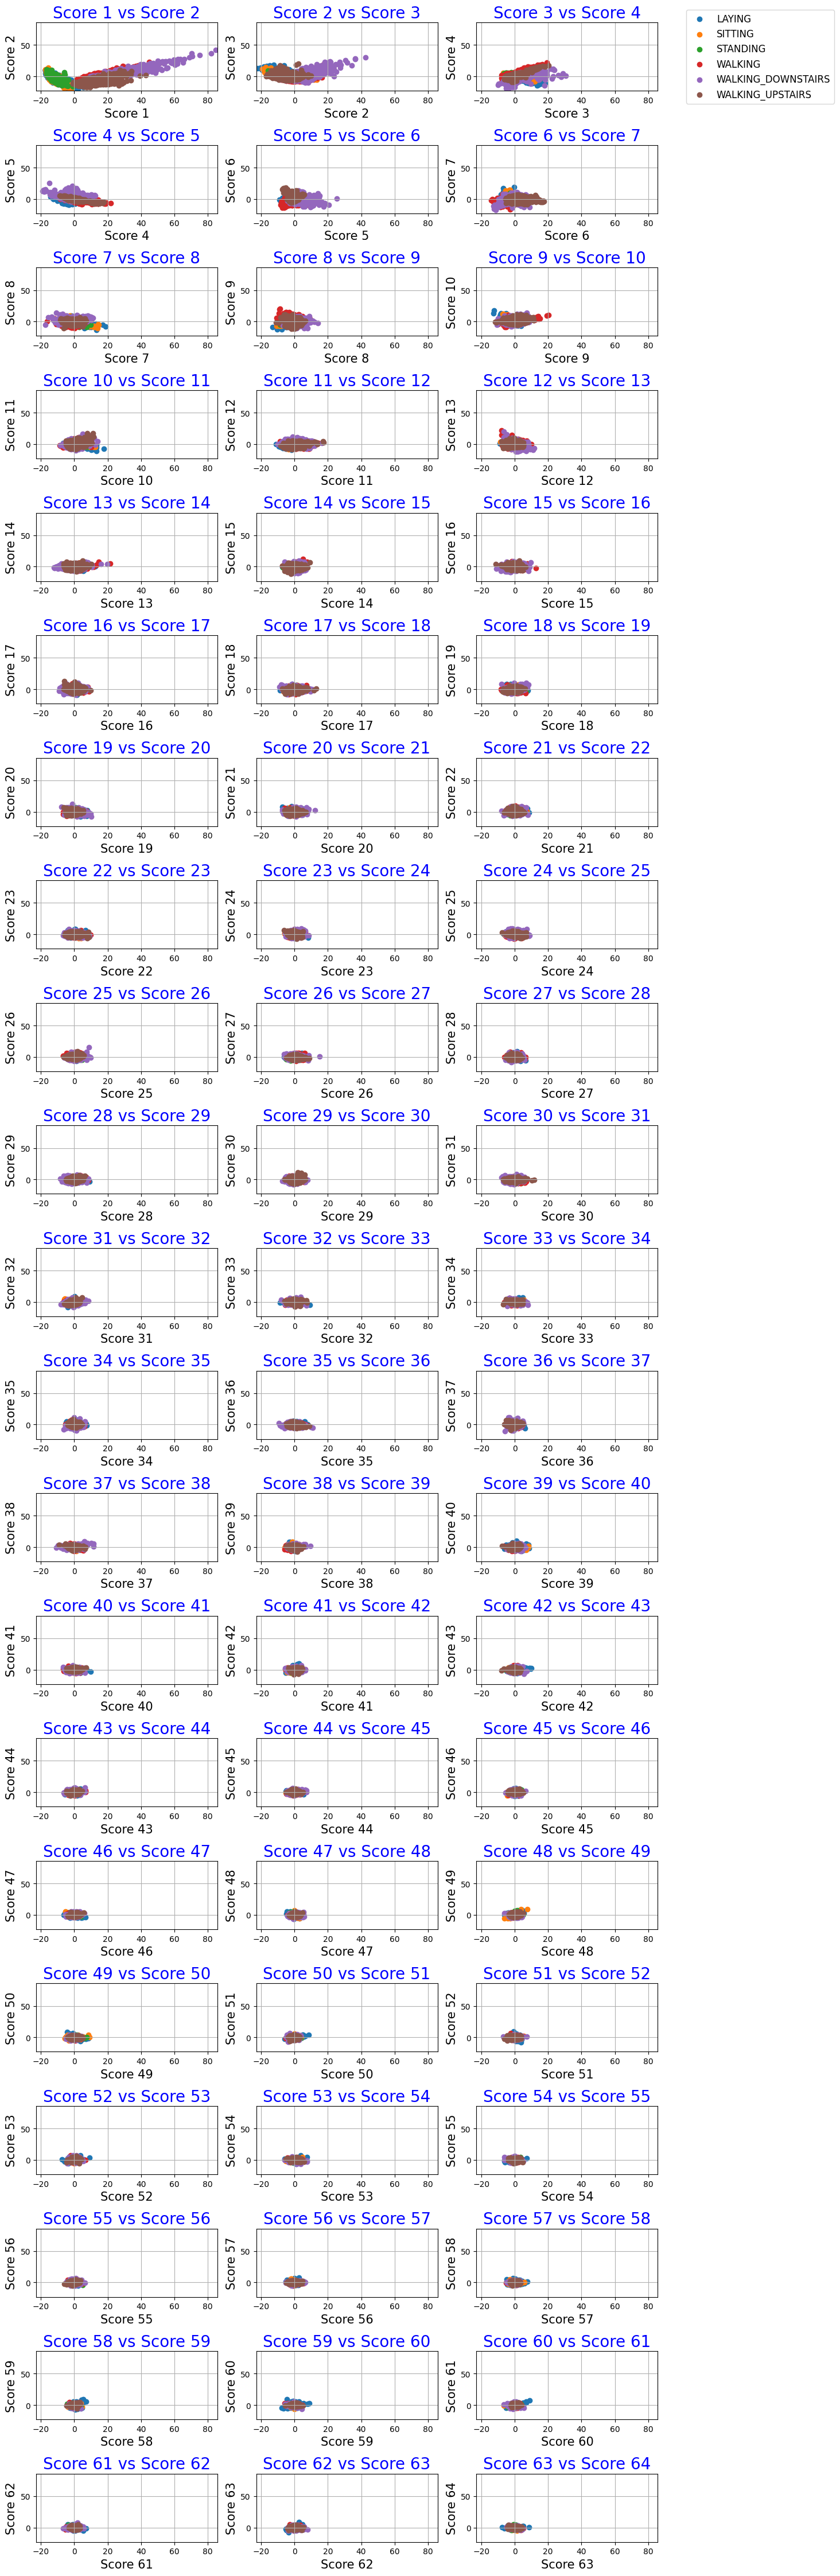

In [ ]:
rows = 21
cols = 3

fig, ax = plt.subplots(rows, cols, figsize = (15, 45))

axf = ax.flatten()

x_min, x_max = df_train_pc_score.min().min() - 1, df_train_pc_score.max().max() + 1
y_min, y_max = df_train_pc_score.min().min() - 1, df_train_pc_score.max().max() + 1

for i in range(df_train_pc_score.shape[1]-1):
  for j,label in enumerate(np.unique(y_train)):
    axf[i].scatter(df_train_pc_score.iloc[y_train.values == label, i], df_train_pc_score.iloc[y_train.values == label, (i+1)], label = activity_labels[j])

  axf[i].set_title(f"Score {i+1} vs Score {i+2}", fontsize = 20, color = 'blue')
  axf[i].set_xlabel(f"Score {i+1}", fontsize = 15)
  axf[i].set_ylabel(f"Score {i+2}", fontsize = 15)
  axf[i].set_xlim([x_min, x_max])
  axf[i].set_ylim([y_min, y_max])
  axf[i].grid()

  if i == (cols - 1):
    axf[i].legend(fontsize = 12,
                  loc = 'right', bbox_to_anchor = (2.0, 0.5),
                  ncol = 1)

for j in range(i+1, len(axf)):
  axf[j].remove()

plt.tight_layout()
plt.show()

Since the first few PCs explained over half of the variance, it is not surprising that we see more most clear structure between the different activities along the direction of these PCs. For higher PCs, the variance is much smaller, and consequently there is much less structure.

## Factor Analysis (FA)

While the key concept in PCA is variance, the key concept in FA is **latent variable**.

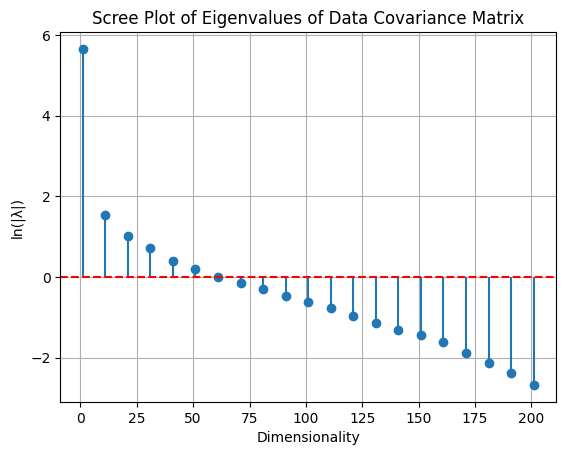

In [ ]:
eval, evec = eig(df_train_scaled[X_name_num].cov().values)

x = np.arange(1, df_train_scaled[X_name_num].shape[1] + 1)

N, step = 210, 10

log_abs_eval = np.log(np.abs(eval))

plt.stem(x[:N:step], log_abs_eval[:N:step], basefmt = " ")
plt.axhline(0., color = 'r', linestyle = '--')
plt.title('Scree Plot of Eigenvalues of Data Covariance Matrix')
plt.xlabel('Dimensionality')
plt.ylabel('ln(|λ|)')
plt.grid()

In [ ]:
# Find number of components using Kaiser criterion (keep eigenvalues greater than 1 (or ln(λ) > 0))
n_factors = np.sum(log_abs_eval > 0)

print(f"Number of significant eigenvalues: {n_factors} ")

Number of significant eigenvalues: 61 


In [ ]:
fa = FactorAnalysis(n_components = n_factors, random_state = random_state)
fa.fit(df_train_scaled[X_name_num]) ;

Store the projected data in a dataframe. Each column represents "score", or representation of the data in one of the dimensions of the lower-dimensional space.

In [ ]:
# Train
df_train_fa_score = pd.DataFrame(fa.transform(df_train_scaled[X_name_num]),
                                 columns = [f'score_{i+1}' for i in range(n_factors)])

# Test
df_test_fa_score = pd.DataFrame(fa.transform(df_test_scaled[X_name_num]),
                                columns = [f'score_{i+1}' for i in range(n_factors)])

In [ ]:
print(f"Number of features in PC project data: {df_train_pc_score.shape[1]}")
print(f"Number of features in FA project data: {df_train_fa_score.shape[1]}")

Number of features in PC project data: 64
Number of features in FA project data: 61


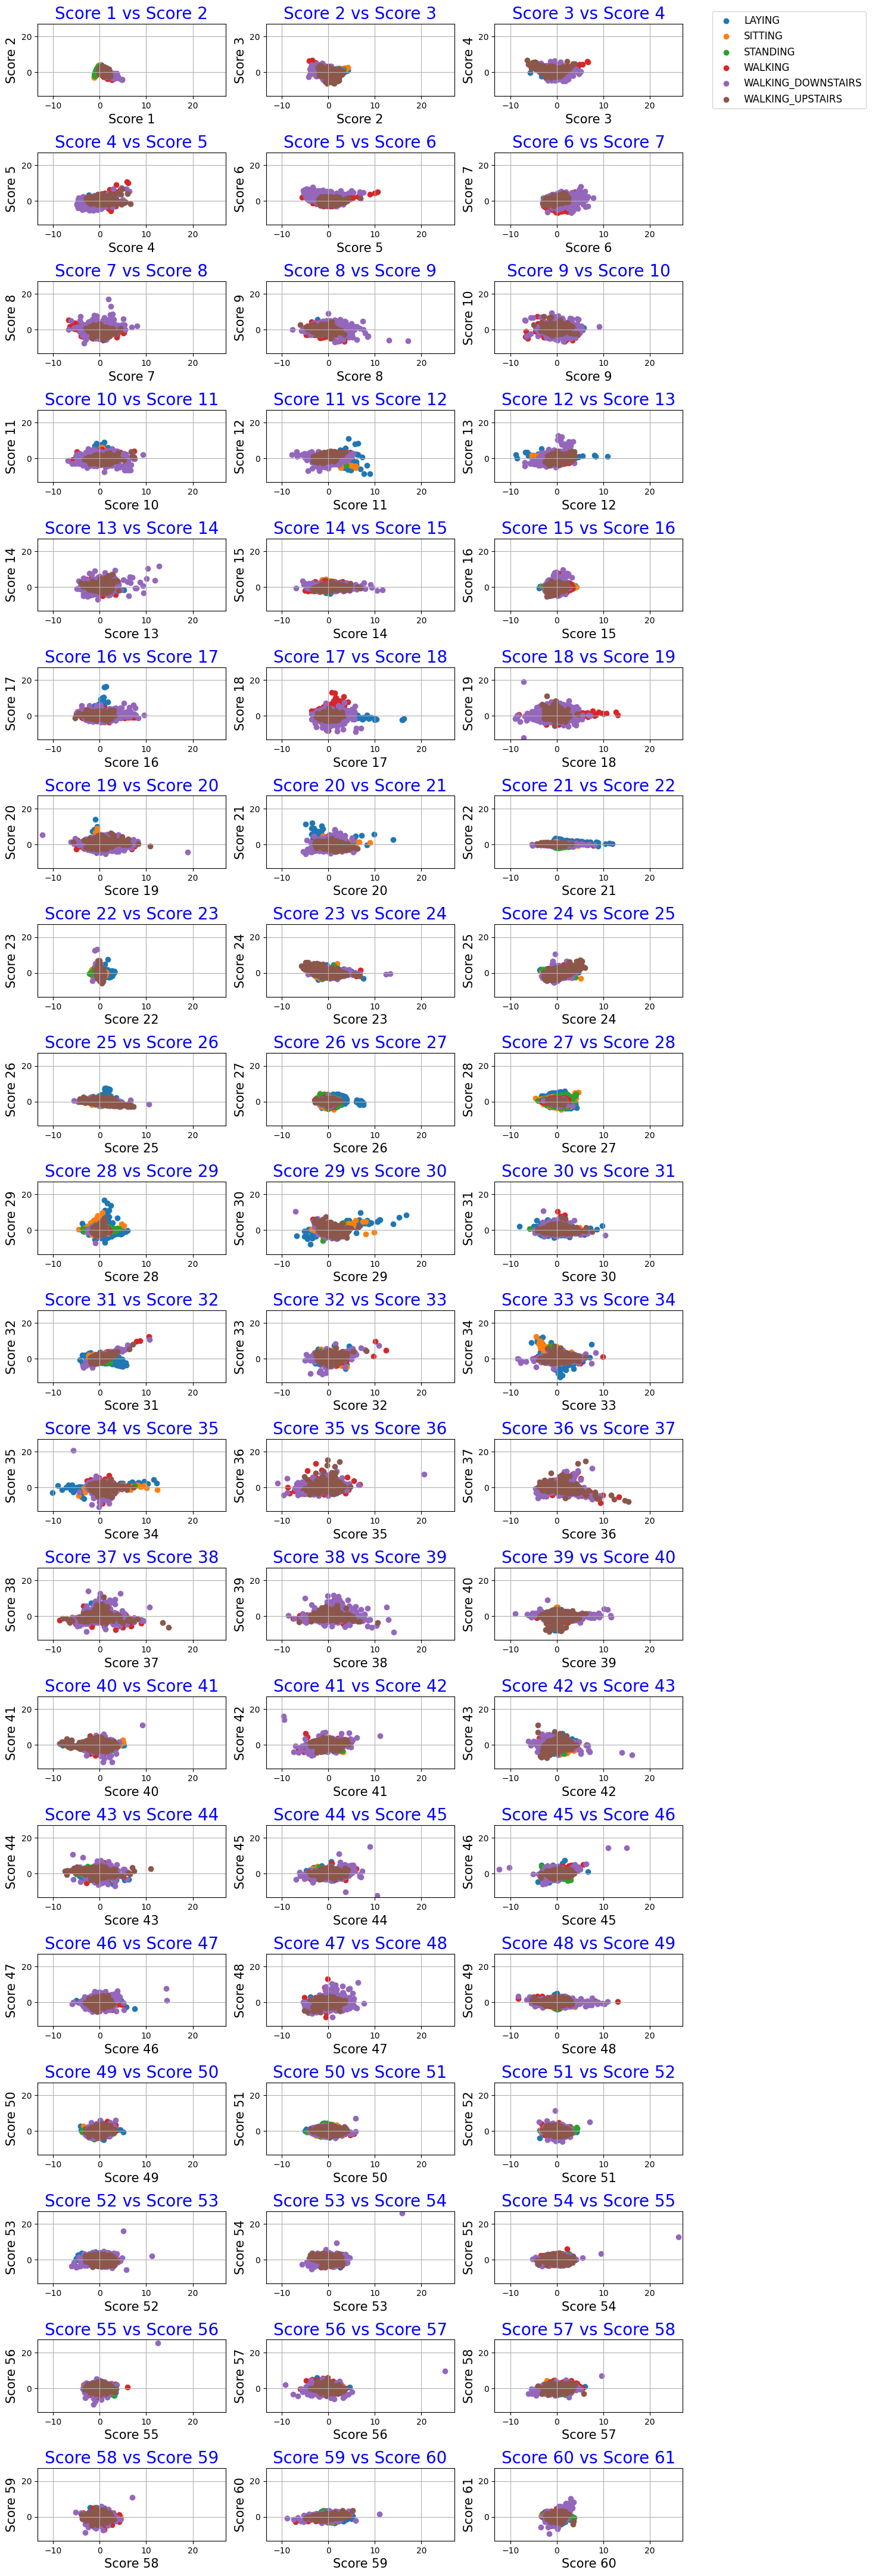

In [ ]:
rows = 21
cols = 3

fig, ax = plt.subplots(rows, cols, figsize = (15, 45))

axf = ax.flatten()

x_min, x_max = df_train_fa_score.min().min() - 1, df_train_fa_score.max().max() + 1
y_min, y_max = df_train_fa_score.min().min() - 1, df_train_fa_score.max().max() + 1

for i in range(df_train_fa_score.shape[1]-1):
  for j,label in enumerate(np.unique(y_train)):
    axf[i].scatter(df_train_fa_score.iloc[y_train.values == label, i], df_train_fa_score.iloc[y_train.values == label, (i+1)], label = activity_labels[j])

  axf[i].set_title(f"Score {i+1} vs Score {i+2}", fontsize = 20, color = 'blue')
  axf[i].set_xlabel(f"Score {i+1}", fontsize = 15)
  axf[i].set_ylabel(f"Score {i+2}", fontsize = 15)
  axf[i].set_xlim([x_min, x_max])
  axf[i].set_ylim([y_min, y_max])
  axf[i].grid()

  if i == (cols - 1):
    axf[i].legend(fontsize = 12,
                  loc = 'right', bbox_to_anchor = (2.0, 0.5),
                  ncol = 1)

for j in range(i+1, len(axf)):
  axf[j].remove()

plt.tight_layout()
plt.show()

We now have reduced the dimensionaly of our data using both PCA and FA. Unlike in PCA, where the goal is to capture hte maximum variance with each successive component, the goal of FA is to unobserved (latent) variables that can explain the correlation in the data.

These two methods are useful **unsupervised** learning (USL) techniques, when we do not have a priori knowledge of the labeling of each observation.



## Linear Discriminant Analysis (LDA)

Since we happen to have label information, we can also employ **Linear Discriminant Analysis** (LDA), to reduce dimensionality, which is a **supervised** learning problem. The goal of LDA is to find linear combinations of features (called "discriminants") that maximize the separation between classes while minimizing the variance with each class.

In [ ]:
lda = LinearDiscriminantAnalysis()

lda.fit(df_train_scaled[X_name_num], y_train) ;

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
n_discriminants = len(lda.get_feature_names_out())

print(f"Number of features in original data: {df_train_scaled[X_name_num].shape[1]}")
print(f"Number of features in LDA projected data: {n_discriminants}")

Number of features in original data: 561
Number of features in LDA projected data: 5


In [ ]:
df_train_lda_score = pd.DataFrame(lda.transform(df_train_scaled[X_name_num]),
                                 columns = [f'score_{i+1}' for i in range(n_discriminants)])

df_test_lda_score = pd.DataFrame(lda.transform(df_test_scaled[X_name_num]),
                                 columns = [f'score_{i+1}' for i in range(n_discriminants)])

We can inspect the variance of each discriminant:

In [ ]:
print(df_train_lda_score.var(0))

score_1    177.780117
score_2     43.067067
score_3     14.092787
score_4      7.840822
score_5      3.166092
dtype: float64


We see that the discriminants have descending variance.

Let's plot them to visualize there separation in the activity classes.

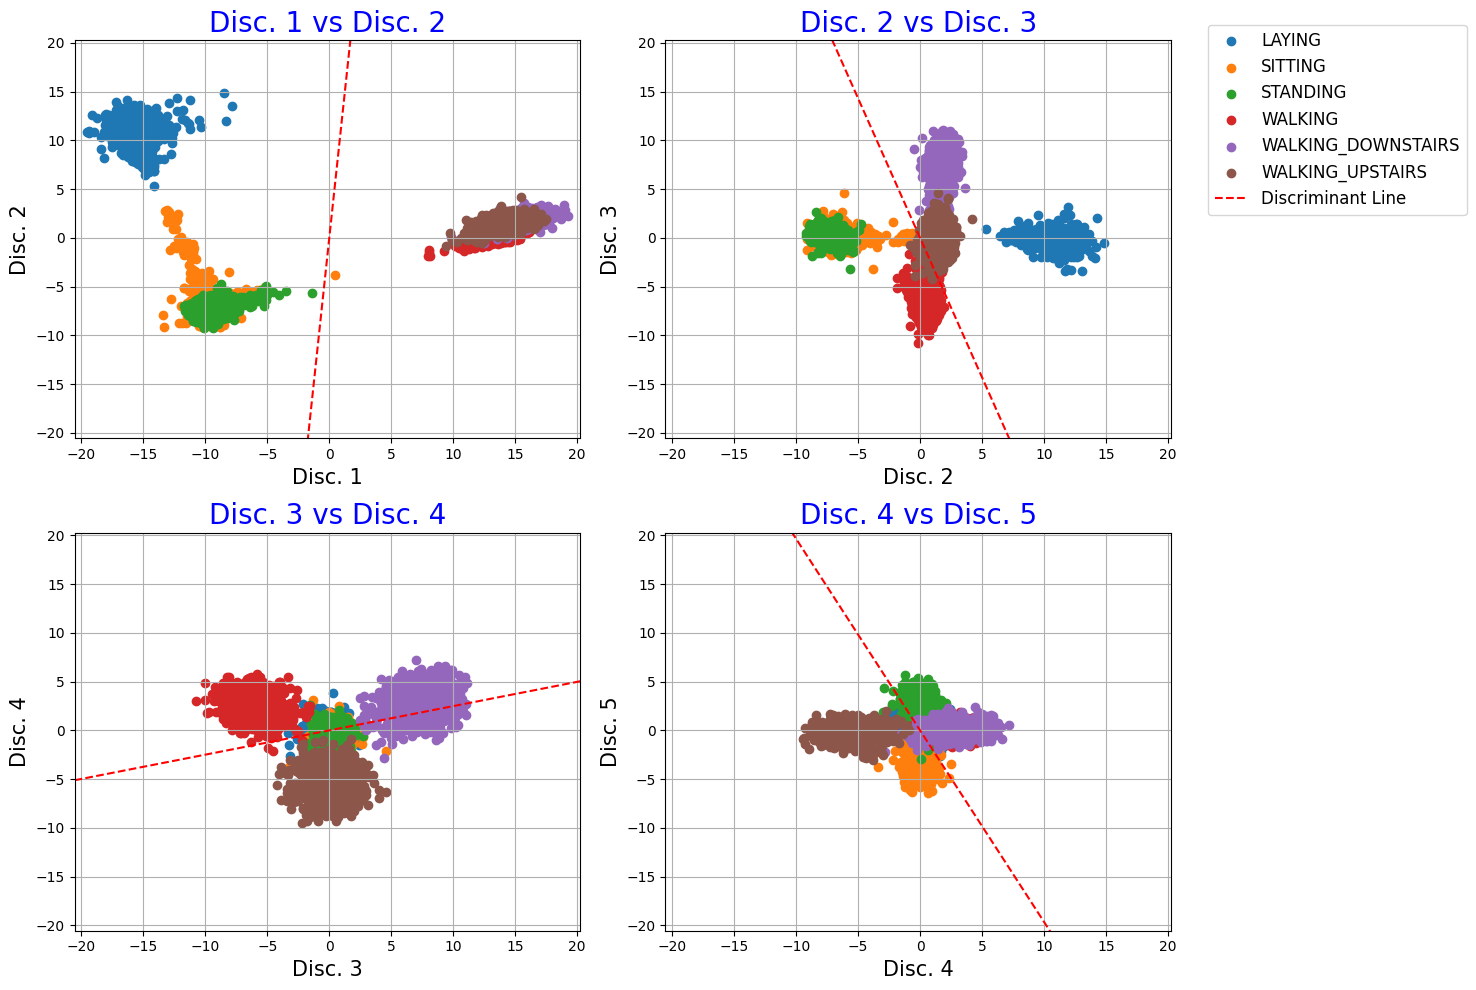

In [ ]:
rows = 2
cols = 2

fig, ax = plt.subplots(2, 2, figsize = (15, 10))

x_min, x_max = df_train_lda_score.min().min() - 1, df_train_lda_score.max().max() + 1
y_min, y_max = df_train_lda_score.min().min() - 1, df_train_lda_score.max().max() + 1

coef = lda.scalings_
intercept = lda.intercept_

axf = ax.flatten()
for i in range(n_discriminants-1):
  for j,label in enumerate(np.unique(y_train)):
    axf[i].scatter(df_train_lda_score.iloc[y_train.values == label, i],
                   df_train_lda_score.iloc[y_train.values == label, (i+1)],
                   label = activity_labels[j])

  ## Add discriminant line
  xx = np.linspace(x_min,  x_max)
  yy = (-coef[i, 0] / coef[i, 1]) * xx  # Calculate the equation of the line
  axf[i].plot(xx, yy, linestyle='--', color='red', label='Discriminant Line')
  ##

  axf[i].set_title(f"Disc. {i+1} vs Disc. {i+2}", fontsize = 20, color = 'blue')
  axf[i].set_xlabel(f"Disc. {i+1}", fontsize = 15)
  axf[i].set_ylabel(f"Disc. {i+2}", fontsize = 15)
  axf[i].set_xlim([x_min, x_max])
  axf[i].set_ylim([y_min, y_max])
  axf[i].grid()

  if i == (cols - 1):
    axf[i].legend(fontsize = 12,
                  loc = 'right', bbox_to_anchor = (1.6, 0.8),
                  ncol = 1)

for j in range(i+1, len(axf)):
  axf[j].remove()

plt.tight_layout()

Interestingly, we see that the frist two discriminants separate well walking and non-walking activities.

## t-Distributed Neighbor Stochastic Embedding (t-SNE)


In [ ]:
tsne = TSNE(n_components = 2,
            random_state = random_state)

tsne_train = tsne.fit_transform(df_train_scaled[X_name_num])

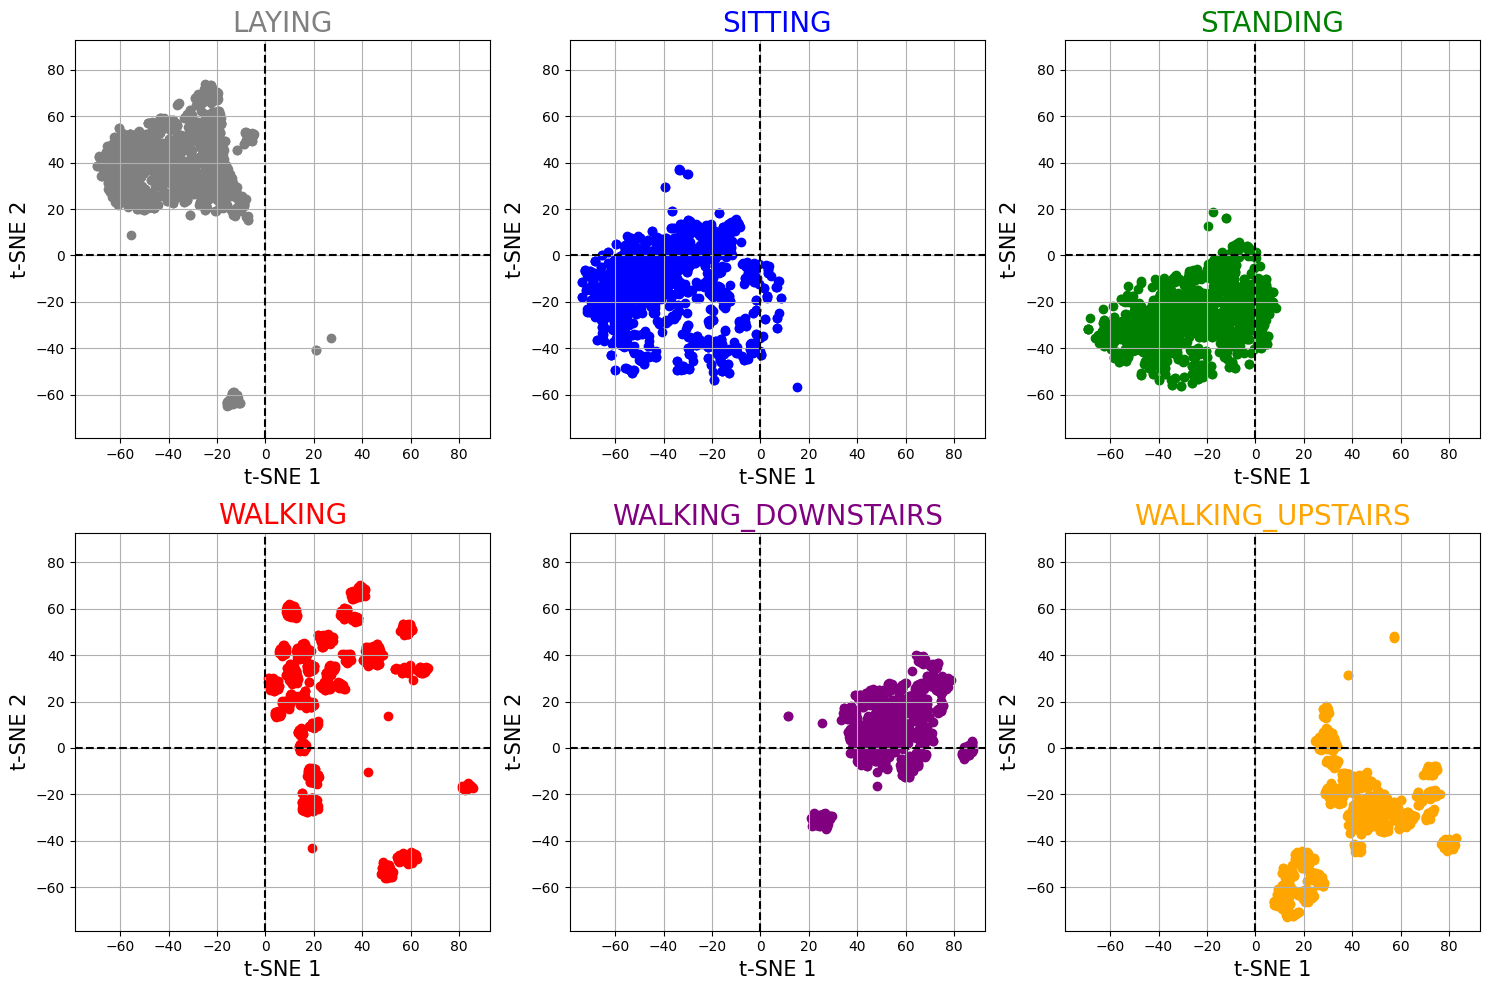

In [ ]:

colors = ['gray', 'blue', 'green', 'red', 'purple', 'orange']

fig, ax = plt.subplots(2, 3, figsize = (15, 10))

axf = ax.flatten()

min_, max_ = tsne_train.min() - 5, tsne_train.max() + 5

for i, label in enumerate(np.unique(y_train)):
  axf[i].scatter(tsne_train[y_train_label_encoded.values.squeeze() == i, 0],
                 tsne_train[y_train_label_encoded.values.squeeze() == i, 1],
                 color = colors[i], label = activity_labels[i])

  axf[i].set_xlabel('t-SNE 1', fontsize = 15)
  axf[i].set_ylabel('t-SNE 2', fontsize = 15)
  axf[i].set_xlim([min_, max_])
  axf[i].set_ylim([min_, max_])

  axf[i].axhline(0, color = 'black', linestyle = '--')
  axf[i].axvline(0, color = 'black', linestyle = '--')
  axf[i].grid()

  axf[i].set_title(activity_labels[i], fontsize = 20, color = colors[i])

plt.tight_layout()
plt.show()

A potentially useful observation is that stationary activity (laying, sitting, standing) reside mostly over negative values the first component, while mobile activity (walking, walkding downstairs, walking upstairs) riside mostly over positive values of the first componenent. The second component is less distinguishing, however one potentional aspect of activity being captured may be the general effort of the activity. We see that stationary activities become generally more negative along the second dimension from laying to standing. Likewise, we see that mobile activities tend to more negative values along the second dimension from level walking to walking upstairs.